In [1]:
import pickle
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

D:\python\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\python\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
D:\python\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
D:\python\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)
D:\python\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)

Bad key text.latex.preview in file D:\python\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.f

# Functions for drawing

In [13]:
# define the path
data_path = './experiments/temp'

alg_dict = {'ma':'MADDPG', 'dd':'DDPG'}
limit_exp_const = 4

In [14]:
# obtain the experiment settings from filename
def exp_attr(fname):
    attrs = {}
    name, suffix = fname.split('.')
    attrs['name'] = name
    attrs['out'] = (suffix == 'out')
    attrs['algorithm'], attrs['scenario'], attrs['exp'] = name.split('_')
    #print(attrs)
    return attrs

# read line by line and return the list of dictionaries
# each dict is the parsed result of a line
def extract_results(lines, reward_only=False, time_only=False):
    i = 0
    while lines[i][:3] != 'Sta':
        i+=1
    results = []
    for j in range(i+1, len(lines)-1):
        if lines[j][:6] != 'steps:' and lines[j][:8] != 'mmmaddpg':
            continue
        if reward_only:
            temp_reward = lines[j].split(',')[2].split(':')[-1].strip()
            results.append(float(temp_reward))
        elif time_only:
            temp_time = lines[j].rsplit(' ', 1)[-1]
            results.append(float(temp_time))
        else:
            results.append(read_result(lines[j]))
    return results    

# parse the following stats from a line-- 
# rmaddpg vs rmaddpg steps: 24975, 
# episodes: 1000, 
# mean episode reward: -20.65337843315543, 
# agent episode reward: [-35.78970068087211, 7.568161123858338, 7.568161123858338], 
# time: 83.783
def read_result(line):
    result = {}
    line, time = line.rsplit(',', 1)
    result['time'] = float(time.split()[-1])
    rest = line.split(',',3)
    result['step'] = int(rest[0].split()[-1])
    result['episode'] = int(rest[1].split()[-1])
    result['mean_reward'] = float(rest[2].split()[-1])
    if len(rest) == 4:
        agent_rewards = rest[3].split(': ')[-1].strip('][,').split(', ')
        result['agent_mean_reward'] = [float(r) for r in agent_rewards]
    return result

# return only the mean rewards 
# could be modified / enhanced
def analyze_results(results):
    mean_rewards = [res['mean_reward'] for res in results]
    return mean_rewards

# return all experiment results under the path
# parse all the .out files
def read_path(path):    
    fileList = os.listdir(path)
    all_results = {}
    for fname in fileList:
        if fname[-4]!='.':
            continue
        attrs = exp_attr(fname)
        if not attrs['out']:
            continue
        with open(os.path.join(path, fname), 'r') as f:
            lines = f.readlines()
            results = extract_results(lines)
            f.close()
        attrs['mean_rewards'] = analyze_results(results)
        all_results[attrs['name']] = attrs
    return all_results


# given the experiments results directory, return selected 
# experiment filenames;
# algorithms = [list of algo to be queried]
# scenario = "string of scenario"
def query(path, algorithm, scenario=None, limit_exp = limit_exp_const):
    fileList = os.listdir(path)
    results = [f for f in fileList if f[-4:]=='.out']
    s_flag = (scenario is not None)
    if (not s_flag):
        raise ValueError("Cannot query algorithms")
    if s_flag:
        temp_results = []
        for f in results:
            if len(f.split('.')[0].split('_')) != 3:
                continue
            algo, sc, exp = f.split('.')[0].split('_')
            if sc != scenario:
                continue
            if algo != algorithm:
                continue
            if exp[0] != 'e':
                continue
            if int(exp[1:]) > limit_exp:
                continue
            temp_results.append(f)
        results = temp_results
    results = [os.path.join(path, res) for res in results]
    return results
    

# plot the mean rewards, could be enhanced
def plot_rewards(list_rewards, labels, figsize=(10,6)):
    plt.figure(figsize=figsize)
    plt.xlabel('episodes(k)')
    plt.ylabel('rewards')
    for rewards, label in zip(list_rewards, labels):
        plt.plot(list(range(len(rewards))), rewards, '-',label=label)
    plt.legend()
    plt.grid(True)
    
def add_entries(files, scenario, return_time=False):
    columns=['Algorithm','Episode(k)','Reward']
    df = None
    for fname in files:
        f_attr = exp_attr(os.path.basename(fname))
        if f_attr['scenario']!=scenario:
            continue
        alg = f_attr['algorithm']
        #print(alg, attempt, uv)
        with open(fname, 'r') as f:
            lines = f.readlines()
            if return_time:
                entries = extract_results(lines, time_only=True)
            else:
                entries = extract_results(lines, reward_only=True)
            results = [[alg_dict[alg], i+1, r] \
                       for (i,r) in enumerate(entries)]
            
            temp_df = pd.DataFrame(results, columns=columns)
            if df is None:
                df = temp_df
            else:
                df = df.append(temp_df,ignore_index=True)
            f.close()
    #print(df)
    return df

def aggregate_df(scenario, print_fs=False):
    ma_fs = query(baseline_ma_path, scenario)
    m3_fs = query(baseline_m3_path, scenario)
    all_fs = ma_fs + m3_fs
    if print_fs:
        for fn in all_fs:
            print(fn)
    return add_entries(all_fs, scenario)

def read_reward_for_one_algorithm_one_scenario(path, algo, scenario):
    files = query(path, algo, scenario)
    #print(files)
    return add_entries(files, scenario)

def read_reward_for_one_scenario(scenario):
    ma_data = read_reward_for_one_algorithm_one_scenario(data_path, 'ma', scenario)
    dd_data = read_reward_for_one_algorithm_one_scenario(data_path, 'dd', scenario)
    res = ma_data
    res = res.append(dd_data, ignore_index=True)
    return res

def plt_cooperative_scenario(scenario):
    res = read_reward_for_one_scenario(scenario)
    f = plt.figure(figsize=(10, 8))
    font_size = 25
    with sns.axes_style("darkgrid"):
        sns.lineplot(data=res, \
                     x='Episode(k)', y='Reward', \
                     hue='Algorithm',ci = 100, lw=3)
    plt.xlabel('episode(k)',fontsize=font_size)# x轴标签
    plt.ylabel('mean episode reward', fontsize=font_size)# y轴标签
    plt.legend(fontsize = 18)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.show()

# Comparison to Decentralized Reinforcement Learning Methods

## Cooperative Communication scenario

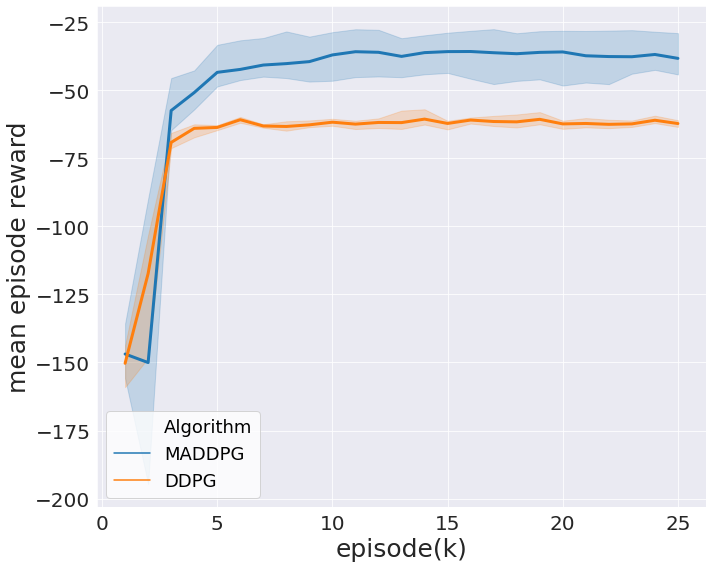

In [16]:
plt_cooperative_scenario('s2')

## Cooperative Navigation scenario

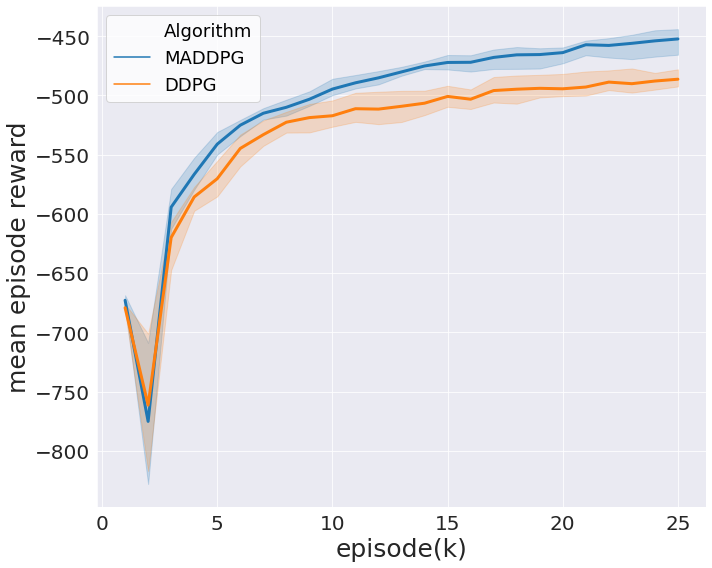

In [17]:
plt_cooperative_scenario('s3')